In [1]:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
# oof_fc, oof_sd, oof_pso, oof_dso by type with bond lengths, that is nb6 plus bond lengths

In [2]:
import numpy as np
import pandas as pd
import os

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

from artgor_utils import *

In [3]:
file_folder = '../data'
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')
scalar_coupling_contributions = pd.read_csv(f'{file_folder}/scalar_coupling_contributions.csv')

In [4]:
from tqdm import tqdm_notebook as tqdm
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

#structures = pd.read_csv(structures, dtype={'atom_index':np.int8})

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

display(structures.head())

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


HBox(children=(IntProgress(value=0, max=2358657), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2358657), HTML(value='')))

molecule_name  atom_index atom             x             y  \
0  dsgdb9nsd_000001           0    C -0.0126981359  1.0858041580   
1  dsgdb9nsd_000001           1    H  0.0021504160 -0.0060313176   
2  dsgdb9nsd_000001           2    H  1.0117308430  1.4637511620   
3  dsgdb9nsd_000001           3    H -0.5408150690  1.4475266140   
4  dsgdb9nsd_000001           4    H -0.5238136345  1.4379326440   

              z    EN   rad  
0  0.0080009958  2.55  0.82  
1  0.0019761204  2.20  0.43  
2  0.0002765748  2.20  0.43  
3 -0.8766437152  2.20  0.43  
4  0.9063972942  2.20  0.43

In [5]:
i_atom = structures['atom_index'].values
p = structures[['x', 'y', 'z']].values
p_compare = p
m = structures['molecule_name'].values
m_compare = m
r = structures['rad'].values
r_compare = r

source_row = np.arange(len(structures))
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating the bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

#bond_data = {'bond_' + str(i):col for i, col in enumerate(np.transpose(bonds))}
#bond_data.update({'bonds_numeric':bonds_numeric, 'n_bonds':n_bonds})

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
display(structures.head(20))

Calculating the bonds


HBox(children=(IntProgress(value=0, max=27), HTML(value='')))


Counting and condensing bonds


HBox(children=(IntProgress(value=0, max=2358657), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2358657), HTML(value='')))

molecule_name  atom_index atom             x             y  \
0   dsgdb9nsd_000001           0    C -0.0126981359  1.0858041580   
1   dsgdb9nsd_000001           1    H  0.0021504160 -0.0060313176   
2   dsgdb9nsd_000001           2    H  1.0117308430  1.4637511620   
3   dsgdb9nsd_000001           3    H -0.5408150690  1.4475266140   
4   dsgdb9nsd_000001           4    H -0.5238136345  1.4379326440   
5   dsgdb9nsd_000002           0    N -0.0404260543  1.0241077530   
6   dsgdb9nsd_000002           1    H  0.0172574639  0.0125452063   
7   dsgdb9nsd_000002           2    H  0.9157893661  1.3587451950   
8   dsgdb9nsd_000002           3    H -0.5202777357  1.3435321260   
9   dsgdb9nsd_000003           0    O -0.0343604951  0.9775395708   
10  dsgdb9nsd_000003           1    H  0.0647664923  0.0205721989   
11  dsgdb9nsd_000003           2    H  0.8717903737  1.3007924050   
12  dsgdb9nsd_000004           0    C  0.5995394918  0.0000000000   
13  dsgdb9nsd_000004           1    C -0.5995394918  0.0000000000   
14  dsgdb9nsd_000004           2    H -1.6616385860  0.0000000000   
15  dsgdb9nsd_000004           3    H  1.6616385860  0.0000000000   
16  dsgdb9nsd_000005           0    C -0.0133239314  1.1324657150   
17  dsgdb9nsd_000005           1    N  0.0023107217 -0.0191585871   
18  dsgdb9nsd_000005           2    H -0.0278026991  2.1989492960   
19  dsgdb9nsd_000007           0    C -0.0187040036  1.5255820150   

               z    EN   rad  bond_lengths_mean  n_bonds  
0   0.0080009958  2.55  0.82  1.091949701309204        4  
1   0.0019761204  2.20  0.43  1.091953039169312        1  
2   0.0002765748  2.20  0.43  1.091951608657837        1  
3  -0.8766437152  2.20  0.43  1.091946363449097        1  
4   0.9063972942  2.20  0.43  1.091947555541992        1  
5   0.0625637998  3.04  0.80  1.017194986343384        3  
6  -0.0273771593  2.20  0.43  1.017189979553223        1  
7  -0.0287577581  2.20  0.43  1.017187237739563        1  
8  -0.7755426124  2.20  0.43  1.017207860946655        1  
9   0.0076015923  3.44  0.78  0.962106823921204        2  
10  0.0015346341  2.20  0.43  0.962106823921204        1  
11  0.0006931336  2.20  0.43  0.962106823921204        1  
12  1.0000000000  2.55  0.82  1.130589008331299        2  
13  1.0000000000  2.55  0.82  1.130589008331299        2  
14  1.0000000000  2.20  0.43  1.062099099159241        1  
15  1.0000000000  2.20  0.43  1.062099099159241        1  
16  0.0082758861  2.55  0.82  1.109173059463501        2  
17  0.0019287305  3.04  0.80  1.151747941970825        1  
18  0.0141537903  2.20  0.43  1.066598057746887        1  
19  0.0104328082  2.55  0.82  1.203627109527588        4

In [6]:
train = pd.merge(train, scalar_coupling_contributions, how = 'left',
                  left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                  right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

In [7]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [8]:
train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [9]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

In [10]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

In [11]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 470.89 Mb (59.8% reduction)
Mem. usage decreased to 229.39 Mb (57.1% reduction)


In [12]:
def create_features_full(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_median'] = df.groupby('molecule_name')['dist'].transform('median')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['molecule_dist_std'] = df.groupby('molecule_name')['dist'].transform('std')
    
    
    
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df['type_0_couples_count'] = df.groupby(['molecule_name', 'type_0'])['id'].transform('count')
    df['type_1_couples_count'] = df.groupby(['molecule_name', 'type_1'])['id'].transform('count')
    
#     df['molecule_distx_mean'] = df.groupby('molecule_name')['dist_x'].transform('mean')
#     df['molecule_distx_median'] = df.groupby('molecule_name')['dist_x'].transform('median')
#     df['molecule_distx_min'] = df.groupby('molecule_name')['dist_x'].transform('min')
#     df['molecule_distx_max'] = df.groupby('molecule_name')['dist_x'].transform('max')
#     df['molecule_distx_std'] = df.groupby('molecule_name')['dist_x'].transform('std')
    
    
    
#     df['molecule_disty_mean'] = df.groupby('molecule_name')['dist_y'].transform('mean')
#     df['molecule_disty_median'] = df.groupby('molecule_name')['dist_y'].transform('median')
#     df['molecule_disty_min'] = df.groupby('molecule_name')['dist_y'].transform('min')
#     df['molecule_disty_max'] = df.groupby('molecule_name')['dist_y'].transform('max')
#     df['molecule_disty_std'] = df.groupby('molecule_name')['dist_y'].transform('std')
   
   
    
    
#     df['molecule_distz_mean'] = df.groupby('molecule_name')['dist_z'].transform('mean')
#     df['molecule_distz_median'] = df.groupby('molecule_name')['dist_z'].transform('median')
#     df['molecule_distz_min'] = df.groupby('molecule_name')['dist_z'].transform('min')
#     df['molecule_distz_max'] = df.groupby('molecule_name')['dist_z'].transform('max')
#     df['molecule_distz_std'] = df.groupby('molecule_name')['dist_z'].transform('std')
    
   
    
    
    num_cols = ['x_1', 'y_1', 'z_1', 'dist', 'dist_x', 'dist_y', 'dist_z']
    cat_cols = ['atom_index_0', 'atom_index_1', 'type', 'atom_1', 'type_0']
    aggs = ['mean', 'max', 'std', 'min', 'skew', 'median']
    for col in cat_cols:
        df[f'molecule_{col}_count'] = df.groupby('molecule_name')[col].transform('count')

    for cat_col in tqdm_notebook(cat_cols):
        for num_col in num_cols:
            for agg in aggs:
                df[f'molecule_{cat_col}_{num_col}_{agg}'] = df.groupby(['molecule_name', cat_col])[num_col].transform(agg)
                df[f'molecule_{cat_col}_{num_col}_{agg}_diff'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] - df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_div'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] / df[num_col]
#                 df[f'molecule_{cat_col}_{num_col}_{agg}_sum'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] + df[num_col]
#                 df[f'molecule_{cat_col}_{num_col}_{agg}_mult'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] * df[num_col]


    df = reduce_mem_usage(df)
    return df

In [13]:
train = create_features_full(train)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 10261.92 Mb (-56.9% reduction)


In [14]:
test = create_features_full(test)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


Mem. usage decreased to 5489.76 Mb (-57.4% reduction)


In [15]:
# train.to_csv('../cache/train2.csv', index=False)
# test.to_csv('../cache/test2.csv', index=False)

In [16]:
# train = pd.read_csv('../cache/train2.csv')
# test = pd.read_csv('../cache/test2.csv')

In [17]:
for f in ['atom_index_0', 'atom_index_1', 'atom_1', 'type_0', 'type', 'atom_0', 'type_1']:
#     if f in good_columns:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [18]:
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

In [19]:
good_columns = [
'molecule_atom_index_0_dist_min',
'molecule_atom_index_0_dist_max',
'molecule_atom_index_1_dist_min',
'molecule_atom_index_0_dist_mean',
'molecule_atom_index_0_dist_std',
'dist',
'molecule_atom_index_1_dist_std',
'molecule_atom_index_1_dist_max',
'molecule_atom_index_1_dist_mean',
'molecule_atom_index_0_dist_max_diff',
'molecule_atom_index_0_dist_max_div',
'molecule_atom_index_0_dist_std_diff',
'molecule_atom_index_0_dist_std_div',
'atom_0_couples_count',
'molecule_atom_index_0_dist_min_div',
'molecule_atom_index_1_dist_std_diff',
'molecule_atom_index_0_dist_mean_div',
'atom_1_couples_count',
'molecule_atom_index_0_dist_mean_diff',
'molecule_couples',
'atom_index_1',
'molecule_dist_mean',
'molecule_atom_index_1_dist_max_diff',
'molecule_atom_index_0_y_1_std',
'molecule_atom_index_1_dist_mean_diff',
'molecule_atom_index_1_dist_std_div',
'molecule_atom_index_1_dist_mean_div',
'molecule_atom_index_1_dist_min_diff',
'molecule_atom_index_1_dist_min_div',
'molecule_atom_index_1_dist_max_div',
'molecule_atom_index_0_z_1_std',
'y_0',
'molecule_type_dist_std_diff',
'molecule_atom_1_dist_min_diff',
'molecule_atom_index_0_x_1_std',
'molecule_dist_min',
'molecule_atom_index_0_dist_min_diff',
'molecule_atom_index_0_y_1_mean_diff',
'molecule_type_dist_min',
'molecule_atom_1_dist_min_div',
'atom_index_0',
'molecule_dist_max',
'molecule_atom_1_dist_std_diff',
'molecule_type_dist_max',
'molecule_atom_index_0_y_1_max_diff',
'molecule_type_0_dist_std_diff',
'molecule_type_dist_mean_diff',
'molecule_atom_1_dist_mean',
'molecule_atom_index_0_y_1_mean_div',
'molecule_type_dist_mean_div',
'type',
'EN_x', 'rad_x',
'n_bonds_x', 'bond_lengths_mean_x','EN_y', 'rad_y', 'n_bonds_y', 'bond_lengths_mean_y'
]

In [20]:
# for f in ['atom_0', 'type_1']:
# #     if f in good_columns:
#     lbl = LabelEncoder()
#     lbl.fit(list(X[f].values) + list(X_test[f].values))
#     X[f] = lbl.transform(list(X[f].values))
#     X_test[f] = lbl.transform(list(X_test[f].values))

In [21]:
# X = train[good_columns].copy()
# y = train['scalar_coupling_constant']
# X_test = test[good_columns].copy()

In [22]:
# X = train.copy()
# y = train['scalar_coupling_constant']
# del train

# X_test = test.copy()
# del test
# del structures

In [23]:
# X = X.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)

# X_test = X_test.drop(['id', 'molecule_name'], axis=1)

In [24]:
X = train[good_columns].copy()
y1 = train['scalar_coupling_constant']
y_fc = train['fc']
y_sd = train['sd']
y_pso = train['pso']
y_dso = train['dso']
X_test = test[good_columns].copy()

In [25]:
del train, test

In [26]:
import gc
gc.collect()

857

In [27]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [28]:
# params = {'num_leaves': 128,
#           'min_child_samples': 79,
#           'objective': 'regression',
#           'max_depth': 9,
#           'learning_rate': 0.2,
#           "boosting_type": "gbdt",
#           "subsample_freq": 1,
#           "subsample": 0.9,
#           "bagging_seed": 11,
#           "metric": 'mae',
#           "verbosity": -1,
#           'reg_alpha': 0.1,
#           'reg_lambda': 0.3,
#           'colsample_bytree': 1.0
#          }
# result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [29]:
y = y_fc
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [30]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
# sub['scalar_coupling_constant'] = X_short_test['prediction']
# sub.to_csv('../submissions/sub5.csv', index=False)
# sub.head()

Training of type 0
Fold 1 started at Thu Jun 20 18:02:32 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.32255	valid_1's l1: 1.57315
[1000]	training's l1: 1.07318	valid_1's l1: 1.47001
[1500]	training's l1: 0.906118	valid_1's l1: 1.42193
[2000]	training's l1: 0.782917	valid_1's l1: 1.39242
[2500]	training's l1: 0.685154	valid_1's l1: 1.37304
[3000]	training's l1: 0.604615	valid_1's l1: 1.36023
[3500]	training's l1: 0.537169	valid_1's l1: 1.35041
[4000]	training's l1: 0.479551	valid_1's l1: 1.3434
[4500]	training's l1: 0.429726	valid_1's l1: 1.33811
[5000]	training's l1: 0.386944	valid_1's l1: 1.33357
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.386944	valid_1's l1: 1.33357
Fold 2 started at Thu Jun 20 18:06:16 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.3112	valid_1's l1: 1.56464
[1000]	training's l1: 1.06074	valid_1's l1: 1.46259
[1500]	training's l1: 0.895072	valid_1's

Fold 2 started at Thu Jun 20 18:34:06 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.292658	valid_1's l1: 0.614387
[1000]	training's l1: 0.153527	valid_1's l1: 0.594989
[1500]	training's l1: 0.0834425	valid_1's l1: 0.589261
[2000]	training's l1: 0.0470187	valid_1's l1: 0.587325
[2500]	training's l1: 0.0264302	valid_1's l1: 0.586888
[3000]	training's l1: 0.0147837	valid_1's l1: 0.586439
[3500]	training's l1: 0.00837923	valid_1's l1: 0.586262
[4000]	training's l1: 0.00510224	valid_1's l1: 0.586198
[4500]	training's l1: 0.0035399	valid_1's l1: 0.586161
[5000]	training's l1: 0.00277425	valid_1's l1: 0.586143
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00277425	valid_1's l1: 0.586143
Fold 3 started at Thu Jun 20 18:34:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.286771	valid_1's l1: 0.605661
[1000]	training's l1: 0.149206	valid_1's l1: 0.587553
[1500]	training's l1: 0.080

[2500]	training's l1: 0.393578	valid_1's l1: 0.66897
[3000]	training's l1: 0.355292	valid_1's l1: 0.659449
[3500]	training's l1: 0.322374	valid_1's l1: 0.65206
[4000]	training's l1: 0.29407	valid_1's l1: 0.64617
[4500]	training's l1: 0.269511	valid_1's l1: 0.641781
[5000]	training's l1: 0.247609	valid_1's l1: 0.638106
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.247609	valid_1's l1: 0.638106
Fold 4 started at Thu Jun 20 18:57:51 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.698409	valid_1's l1: 0.790834
[1000]	training's l1: 0.575749	valid_1's l1: 0.727411
[1500]	training's l1: 0.49795	valid_1's l1: 0.696125
[2000]	training's l1: 0.440232	valid_1's l1: 0.677638
[2500]	training's l1: 0.394637	valid_1's l1: 0.664554
[3000]	training's l1: 0.356053	valid_1's l1: 0.655084
[3500]	training's l1: 0.323061	valid_1's l1: 0.648106
[4000]	training's l1: 0.294857	valid_1's l1: 0.642746
[4500]	training's l1: 0.270004	valid_1's l

[1500]	training's l1: 0.577874	valid_1's l1: 0.748369
[2000]	training's l1: 0.520295	valid_1's l1: 0.725432
[2500]	training's l1: 0.473727	valid_1's l1: 0.708946
[3000]	training's l1: 0.434639	valid_1's l1: 0.697134
[3500]	training's l1: 0.401037	valid_1's l1: 0.687988
[4000]	training's l1: 0.371706	valid_1's l1: 0.680671
[4500]	training's l1: 0.345362	valid_1's l1: 0.67427
[5000]	training's l1: 0.322122	valid_1's l1: 0.669279
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.322122	valid_1's l1: 0.669279
Fold 5 started at Thu Jun 20 19:52:23 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.778879	valid_1's l1: 0.858226
[1000]	training's l1: 0.656127	valid_1's l1: 0.785324
[1500]	training's l1: 0.579479	valid_1's l1: 0.749174
[2000]	training's l1: 0.520928	valid_1's l1: 0.725979
[2500]	training's l1: 0.474436	valid_1's l1: 0.710262
[3000]	training's l1: 0.43534	valid_1's l1: 0.69794
[3500]	training's l1: 0.401706	valid_1's

In [31]:
oof_fc = X_short['oof'].values
test_oof_fc = X_short_test['prediction'].values

Fold 1 started at Thu Jun 20 20:05:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.00615	valid_1's l1: 1.04248
[1000]	training's l1: 0.886882	valid_1's l1: 0.949517
[1500]	training's l1: 0.814133	valid_1's l1: 0.899095
[2000]	training's l1: 0.761845	valid_1's l1: 0.866411
[2500]	training's l1: 0.719955	valid_1's l1: 0.843112
[3000]	training's l1: 0.68513	valid_1's l1: 0.824743
[3500]	training's l1: 0.654369	valid_1's l1: 0.809441
[4000]	training's l1: 0.627419	valid_1's l1: 0.7969
[4500]	training's l1: 0.603565	valid_1's l1: 0.786461
[5000]	training's l1: 0.582013	valid_1's l1: 0.777629
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.582013	valid_1's l1: 0.777629
Fold 2 started at Thu Jun 20 20:24:12 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.00807	valid_1's l1: 1.04523
[1000]	training's l1: 0.887607	valid_1's l1: 0.95183
[1500]	training's l1: 0.814429	valid_1's l1: 0.9

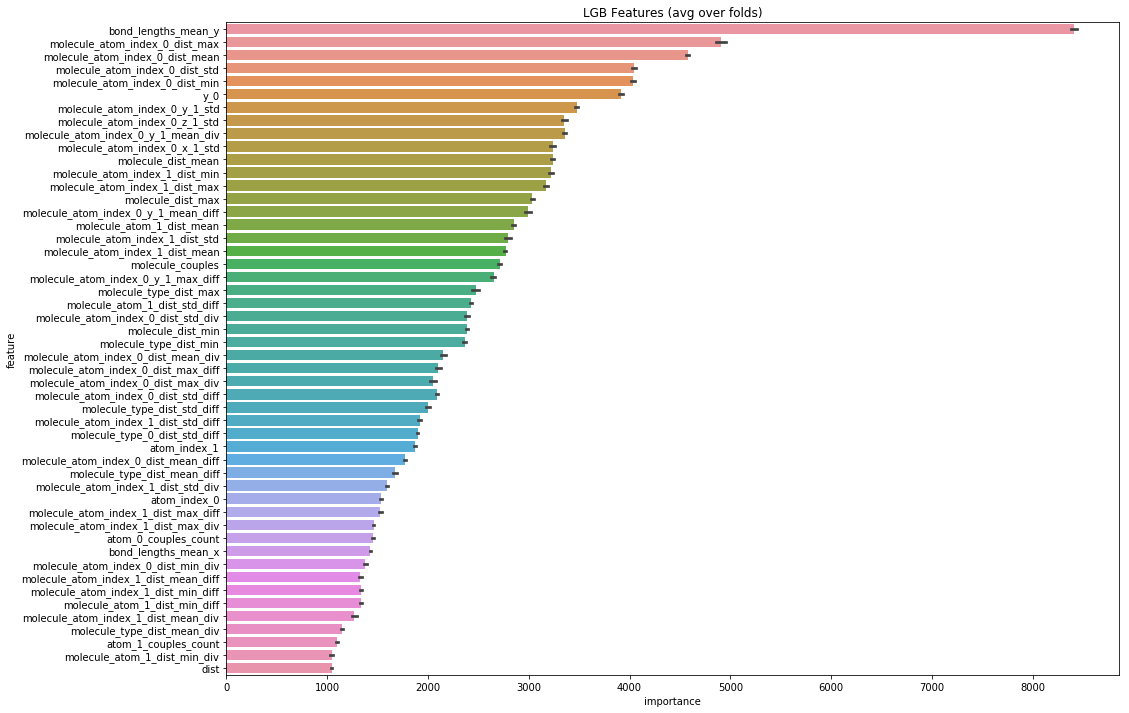

In [32]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb1 = train_model_regression(X=X, X_test=X_test, y=y_fc, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [33]:
oof_fc = result_dict_lgb1['oof']
test_oof_fc = result_dict_lgb1['prediction']

In [34]:
y = y_sd
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [35]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    

Training of type 0
Fold 1 started at Thu Jun 20 21:37:34 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00865452	valid_1's l1: 0.0103397
[1000]	training's l1: 0.00692908	valid_1's l1: 0.00954369
[1500]	training's l1: 0.00584437	valid_1's l1: 0.00915833
[2000]	training's l1: 0.00507434	valid_1's l1: 0.00894678
[2500]	training's l1: 0.0044712	valid_1's l1: 0.00879411
[3000]	training's l1: 0.00399848	valid_1's l1: 0.00868972
[3500]	training's l1: 0.00361131	valid_1's l1: 0.00861436
[4000]	training's l1: 0.00328877	valid_1's l1: 0.00855265
[4500]	training's l1: 0.00301419	valid_1's l1: 0.0085086
[5000]	training's l1: 0.00278086	valid_1's l1: 0.00847024
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00278086	valid_1's l1: 0.00847024
Fold 2 started at Thu Jun 20 21:41:35 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00853996	valid_1's l1: 0.0102725
[1000]	training's l1: 0.0068568

[1500]	training's l1: 0.00153343	valid_1's l1: 0.00595853
[2000]	training's l1: 0.00140204	valid_1's l1: 0.00594561
[2500]	training's l1: 0.0013172	valid_1's l1: 0.00594093
[3000]	training's l1: 0.00125624	valid_1's l1: 0.00593694
[3500]	training's l1: 0.00120844	valid_1's l1: 0.00593482
[4000]	training's l1: 0.00116927	valid_1's l1: 0.00593299
[4500]	training's l1: 0.00113665	valid_1's l1: 0.0059302
Early stopping, best iteration is:
[4571]	training's l1: 0.00113257	valid_1's l1: 0.00592952
Fold 2 started at Thu Jun 20 22:13:21 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0024834	valid_1's l1: 0.00611348
[1000]	training's l1: 0.00178601	valid_1's l1: 0.00601472
[1500]	training's l1: 0.00154461	valid_1's l1: 0.00598712
[2000]	training's l1: 0.00141471	valid_1's l1: 0.00597534
[2500]	training's l1: 0.00132768	valid_1's l1: 0.00596688
[3000]	training's l1: 0.00126695	valid_1's l1: 0.0059621
[3500]	training's l1: 0.00121933	valid_1's l1: 0.005

[2500]	training's l1: 0.00639004	valid_1's l1: 0.0105218
[3000]	training's l1: 0.00579431	valid_1's l1: 0.0103514
[3500]	training's l1: 0.00529596	valid_1's l1: 0.0102191
[4000]	training's l1: 0.0048653	valid_1's l1: 0.0101171
[4500]	training's l1: 0.00449768	valid_1's l1: 0.0100322
[5000]	training's l1: 0.0041748	valid_1's l1: 0.00996405
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0041748	valid_1's l1: 0.00996405
Fold 3 started at Thu Jun 20 22:30:33 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0111139	valid_1's l1: 0.012712
[1000]	training's l1: 0.00917937	valid_1's l1: 0.0116559
[1500]	training's l1: 0.0079768	valid_1's l1: 0.0111333
[2000]	training's l1: 0.00706879	valid_1's l1: 0.0107926
[2500]	training's l1: 0.00634807	valid_1's l1: 0.0105662
[3000]	training's l1: 0.00575139	valid_1's l1: 0.0103824
[3500]	training's l1: 0.0052571	valid_1's l1: 0.0102514
[4000]	training's l1: 0.00483578	valid_1's l1: 0.01014

[5000]	training's l1: 0.00364318	valid_1's l1: 0.00719337
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00364318	valid_1's l1: 0.00719337
Fold 3 started at Thu Jun 20 23:20:25 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00822382	valid_1's l1: 0.00912884
[1000]	training's l1: 0.00698726	valid_1's l1: 0.00841811
[1500]	training's l1: 0.0062131	valid_1's l1: 0.00805583
[2000]	training's l1: 0.0056307	valid_1's l1: 0.00782564
[2500]	training's l1: 0.00516078	valid_1's l1: 0.00765841
[3000]	training's l1: 0.00476553	valid_1's l1: 0.00752662
[3500]	training's l1: 0.00443034	valid_1's l1: 0.00742732
[4000]	training's l1: 0.00413825	valid_1's l1: 0.0073451
[4500]	training's l1: 0.00388329	valid_1's l1: 0.00727755
[5000]	training's l1: 0.00365575	valid_1's l1: 0.00722037
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00365575	valid_1's l1: 0.00722037
Fold 4 started at Thu Jun 20 23:27:29 2019
Train

In [36]:
oof_sd = X_short['oof'].values
test_oof_sd = X_short_test['prediction'].values

Fold 1 started at Thu Jun 20 23:48:27 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0115287	valid_1's l1: 0.0119543
[1000]	training's l1: 0.0101356	valid_1's l1: 0.0108403
[1500]	training's l1: 0.00932659	valid_1's l1: 0.010272
[2000]	training's l1: 0.00874862	valid_1's l1: 0.00990191
[2500]	training's l1: 0.00828014	valid_1's l1: 0.00961991
[3000]	training's l1: 0.00789284	valid_1's l1: 0.00940664
[3500]	training's l1: 0.0075605	valid_1's l1: 0.00923793
[4000]	training's l1: 0.00725925	valid_1's l1: 0.00908711
[4500]	training's l1: 0.00698948	valid_1's l1: 0.00896027
[5000]	training's l1: 0.00674844	valid_1's l1: 0.00885472
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00674844	valid_1's l1: 0.00885472
Fold 2 started at Fri Jun 21 00:07:32 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0114922	valid_1's l1: 0.0119166
[1000]	training's l1: 0.010144	valid_1's l1: 0.0108543


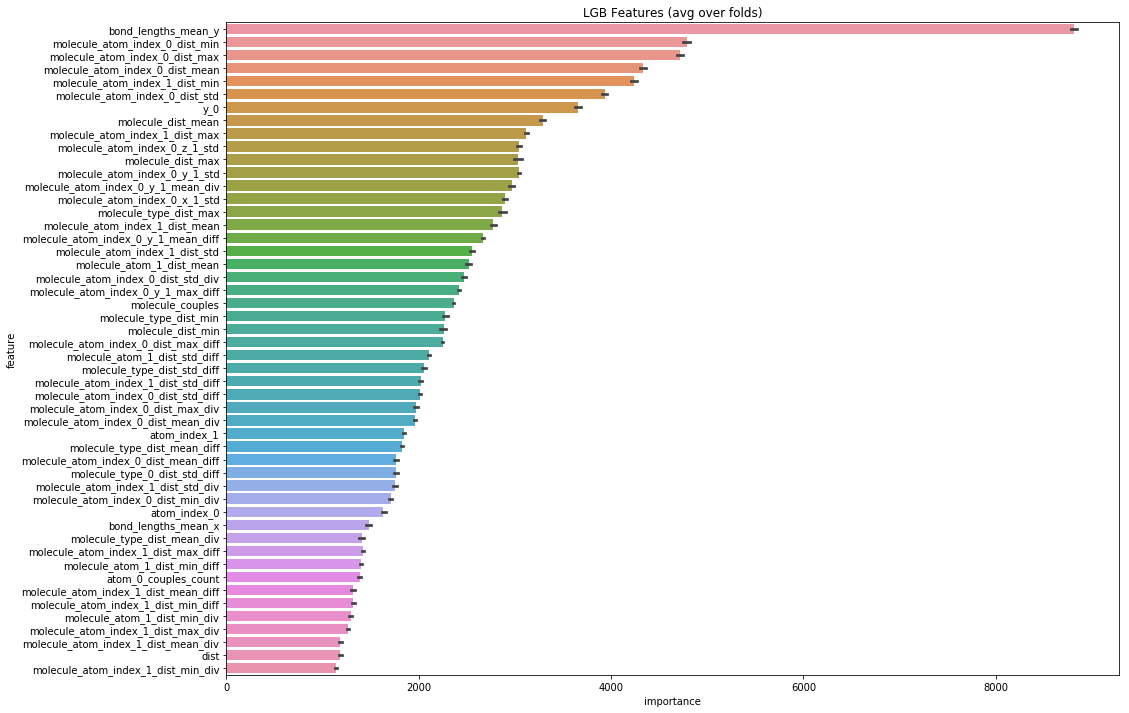

In [37]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb2 = train_model_regression(X=X, X_test=X_test, y=y_sd, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [38]:
oof_sd = result_dict_lgb2['oof']
test_oof_sd = result_dict_lgb2['prediction']

In [39]:
y = y_pso
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [40]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']

Training of type 0
Fold 1 started at Fri Jun 21 01:26:45 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0387794	valid_1's l1: 0.0467629
[1000]	training's l1: 0.0308571	valid_1's l1: 0.0430515
[1500]	training's l1: 0.0259335	valid_1's l1: 0.0413757
[2000]	training's l1: 0.0222821	valid_1's l1: 0.0403445
[2500]	training's l1: 0.0194877	valid_1's l1: 0.0397017
[3000]	training's l1: 0.0171791	valid_1's l1: 0.0392443
[3500]	training's l1: 0.0152694	valid_1's l1: 0.0389008
[4000]	training's l1: 0.0136544	valid_1's l1: 0.0386299
[4500]	training's l1: 0.0122858	valid_1's l1: 0.0384305
[5000]	training's l1: 0.0110986	valid_1's l1: 0.0382566
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0110986	valid_1's l1: 0.0382566
Fold 2 started at Fri Jun 21 01:30:29 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0389692	valid_1's l1: 0.0467495
[1000]	training's l1: 0.0309151	valid_1's l1: 0.043

Fold 2 started at Fri Jun 21 01:58:15 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0167048	valid_1's l1: 0.0431111
[1000]	training's l1: 0.00740803	valid_1's l1: 0.0420889
[1500]	training's l1: 0.00397112	valid_1's l1: 0.0418767
[2000]	training's l1: 0.00279135	valid_1's l1: 0.0418163
[2500]	training's l1: 0.00229752	valid_1's l1: 0.0417901
[3000]	training's l1: 0.00202329	valid_1's l1: 0.0417781
[3500]	training's l1: 0.00184762	valid_1's l1: 0.0417678
[4000]	training's l1: 0.00172291	valid_1's l1: 0.0417605
[4500]	training's l1: 0.00162895	valid_1's l1: 0.0417566
Early stopping, best iteration is:
[4497]	training's l1: 0.0016293	valid_1's l1: 0.0417563
Fold 3 started at Fri Jun 21 01:58:46 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0168972	valid_1's l1: 0.0416256
[1000]	training's l1: 0.00751035	valid_1's l1: 0.0405568
[1500]	training's l1: 0.00400671	valid_1's l1: 0.0402867
[2000]	training's

[4500]	training's l1: 0.0116714	valid_1's l1: 0.0261906
[5000]	training's l1: 0.0107547	valid_1's l1: 0.0259743
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0107547	valid_1's l1: 0.0259743
Fold 4 started at Fri Jun 21 02:21:28 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0300036	valid_1's l1: 0.0337171
[1000]	training's l1: 0.0246906	valid_1's l1: 0.0307395
[1500]	training's l1: 0.0213533	valid_1's l1: 0.0292418
[2000]	training's l1: 0.018873	valid_1's l1: 0.0283026
[2500]	training's l1: 0.0168942	valid_1's l1: 0.0276256
[3000]	training's l1: 0.0152775	valid_1's l1: 0.027126
[3500]	training's l1: 0.0139179	valid_1's l1: 0.0267449
[4000]	training's l1: 0.0127337	valid_1's l1: 0.0264382
[4500]	training's l1: 0.0116933	valid_1's l1: 0.026194
[5000]	training's l1: 0.0107823	valid_1's l1: 0.0259915
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0107823	valid_1's l1: 0.0259915
Fold 5 started at 

[1500]	training's l1: 0.0186872	valid_1's l1: 0.0240752
[2000]	training's l1: 0.0168242	valid_1's l1: 0.0232906
[2500]	training's l1: 0.0153202	valid_1's l1: 0.0227334
[3000]	training's l1: 0.014091	valid_1's l1: 0.0223236
[3500]	training's l1: 0.013035	valid_1's l1: 0.0220068
[4000]	training's l1: 0.0121081	valid_1's l1: 0.0217485
[4500]	training's l1: 0.0112927	valid_1's l1: 0.0215371
[5000]	training's l1: 0.0105581	valid_1's l1: 0.0213531
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0105581	valid_1's l1: 0.0213531
Fold 5 started at Fri Jun 21 03:15:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0252352	valid_1's l1: 0.0278423
[1000]	training's l1: 0.0212484	valid_1's l1: 0.0254062
[1500]	training's l1: 0.0187183	valid_1's l1: 0.0241643
[2000]	training's l1: 0.0168837	valid_1's l1: 0.0234015
[2500]	training's l1: 0.0153847	valid_1's l1: 0.0228497
[3000]	training's l1: 0.0141273	valid_1's l1: 0.0224345
[3500]	tr

In [41]:
oof_pso = X_short['oof'].values
test_oof_pso = X_short_test['prediction'].values

Fold 1 started at Fri Jun 21 03:29:51 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0439549	valid_1's l1: 0.0455169
[1000]	training's l1: 0.0385061	valid_1's l1: 0.0410197
[1500]	training's l1: 0.0352723	valid_1's l1: 0.0386168
[2000]	training's l1: 0.0329628	valid_1's l1: 0.0370651
[2500]	training's l1: 0.031125	valid_1's l1: 0.0359056
[3000]	training's l1: 0.0296109	valid_1's l1: 0.0350127
[3500]	training's l1: 0.0283014	valid_1's l1: 0.0342949
[4000]	training's l1: 0.0271746	valid_1's l1: 0.0337181
[4500]	training's l1: 0.0261488	valid_1's l1: 0.0332097
[5000]	training's l1: 0.0252229	valid_1's l1: 0.0327841
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0252229	valid_1's l1: 0.0327841
Fold 2 started at Fri Jun 21 03:48:37 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0437621	valid_1's l1: 0.0451969
[1000]	training's l1: 0.0384126	valid_1's l1: 0.0408533
[1500]	training

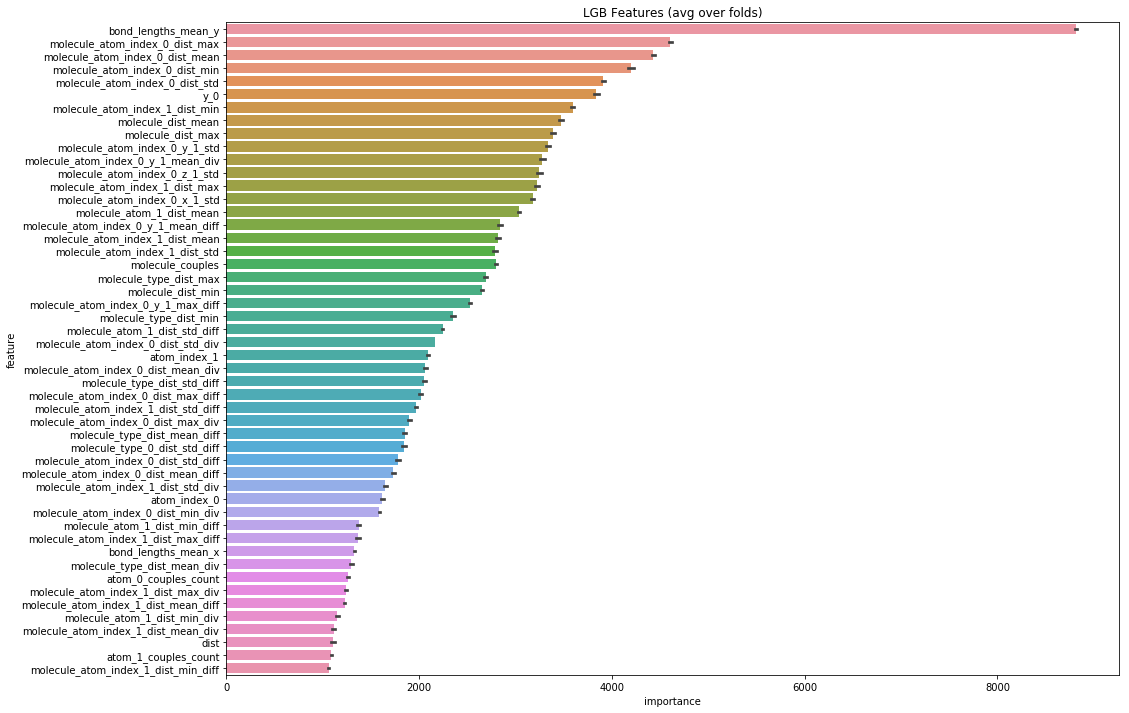

In [42]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb3 = train_model_regression(X=X, X_test=X_test, y=y_pso, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [43]:
oof_pso = result_dict_lgb3['oof']
test_oof_pso = result_dict_lgb3['prediction']

In [44]:
y = y_dso
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [45]:
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']

Training of type 0
Fold 1 started at Fri Jun 21 05:03:56 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.014841	valid_1's l1: 0.0175527
[1000]	training's l1: 0.0118479	valid_1's l1: 0.0160444
[1500]	training's l1: 0.00995992	valid_1's l1: 0.0153015
[2000]	training's l1: 0.00860578	valid_1's l1: 0.0148548
[2500]	training's l1: 0.00754985	valid_1's l1: 0.0145279
[3000]	training's l1: 0.00669944	valid_1's l1: 0.0142947
[3500]	training's l1: 0.00600516	valid_1's l1: 0.0141142
[4000]	training's l1: 0.00542201	valid_1's l1: 0.0139749
[4500]	training's l1: 0.00492464	valid_1's l1: 0.013866
[5000]	training's l1: 0.00450184	valid_1's l1: 0.0137786
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00450184	valid_1's l1: 0.0137786
Fold 2 started at Fri Jun 21 05:07:47 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.01485	valid_1's l1: 0.0174684
[1000]	training's l1: 0.0118798	valid_1's l1: 

[2500]	training's l1: 0.0011945	valid_1's l1: 0.00421148
Early stopping, best iteration is:
[2769]	training's l1: 0.00116685	valid_1's l1: 0.00420693
Fold 2 started at Fri Jun 21 05:36:29 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00198405	valid_1's l1: 0.00446959
[1000]	training's l1: 0.00152347	valid_1's l1: 0.00438133
[1500]	training's l1: 0.00135104	valid_1's l1: 0.00435079
[2000]	training's l1: 0.00125248	valid_1's l1: 0.00433483
[2500]	training's l1: 0.00118879	valid_1's l1: 0.00432438
Early stopping, best iteration is:
[2700]	training's l1: 0.00116759	valid_1's l1: 0.00432019
Fold 3 started at Fri Jun 21 05:36:43 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.00198426	valid_1's l1: 0.00437628
[1000]	training's l1: 0.00152161	valid_1's l1: 0.00428541
[1500]	training's l1: 0.00134995	valid_1's l1: 0.00425879
[2000]	training's l1: 0.00125238	valid_1's l1: 0.00424373
[2500]	training's l1: 0.0

[2000]	training's l1: 0.00978317	valid_1's l1: 0.014509
[2500]	training's l1: 0.00879295	valid_1's l1: 0.0141317
[3000]	training's l1: 0.00798357	valid_1's l1: 0.0138594
[3500]	training's l1: 0.00729858	valid_1's l1: 0.0136458
[4000]	training's l1: 0.00671007	valid_1's l1: 0.01347
[4500]	training's l1: 0.00620014	valid_1's l1: 0.0133329
[5000]	training's l1: 0.00575468	valid_1's l1: 0.0132232
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.00575468	valid_1's l1: 0.0132232
Fold 4 started at Fri Jun 21 05:59:12 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0155251	valid_1's l1: 0.017437
[1000]	training's l1: 0.0127874	valid_1's l1: 0.0158377
[1500]	training's l1: 0.0110806	valid_1's l1: 0.0150123
[2000]	training's l1: 0.00983311	valid_1's l1: 0.0144989
[2500]	training's l1: 0.00883589	valid_1's l1: 0.0141219
[3000]	training's l1: 0.00801277	valid_1's l1: 0.0138432
[3500]	training's l1: 0.00733113	valid_1's l1: 0.0136359

Fold 4 started at Fri Jun 21 06:47:28 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0314003	valid_1's l1: 0.0347619
[1000]	training's l1: 0.0261502	valid_1's l1: 0.0315595
[1500]	training's l1: 0.0229616	valid_1's l1: 0.0300185
[2000]	training's l1: 0.0206228	valid_1's l1: 0.0290795
[2500]	training's l1: 0.018738	valid_1's l1: 0.0283769
[3000]	training's l1: 0.0171889	valid_1's l1: 0.0278852
[3500]	training's l1: 0.0158469	valid_1's l1: 0.0274885
[4000]	training's l1: 0.0146848	valid_1's l1: 0.0271738
[4500]	training's l1: 0.0136488	valid_1's l1: 0.0269055
[5000]	training's l1: 0.0127327	valid_1's l1: 0.0266899
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0127327	valid_1's l1: 0.0266899
Fold 5 started at Fri Jun 21 06:54:22 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0314991	valid_1's l1: 0.0349638
[1000]	training's l1: 0.0262006	valid_1's l1: 0.0316841
[1500]	training

In [46]:
oof_dso = X_short['oof'].values
test_oof_dso = X_short_test['prediction'].values

Fold 1 started at Fri Jun 21 07:11:49 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0376061	valid_1's l1: 0.0391263
[1000]	training's l1: 0.0328086	valid_1's l1: 0.0352608
[1500]	training's l1: 0.0300494	valid_1's l1: 0.0332849
[2000]	training's l1: 0.0280535	valid_1's l1: 0.0319726
[2500]	training's l1: 0.026437	valid_1's l1: 0.0309765
[3000]	training's l1: 0.0251397	valid_1's l1: 0.0302511
[3500]	training's l1: 0.0239829	valid_1's l1: 0.02963
[4000]	training's l1: 0.0229629	valid_1's l1: 0.0291121
[4500]	training's l1: 0.0220663	valid_1's l1: 0.0286836
[5000]	training's l1: 0.0212465	valid_1's l1: 0.0283015
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0212465	valid_1's l1: 0.0283015
Fold 2 started at Fri Jun 21 07:31:00 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0376137	valid_1's l1: 0.0389528
[1000]	training's l1: 0.0328596	valid_1's l1: 0.0351514
[1500]	training's

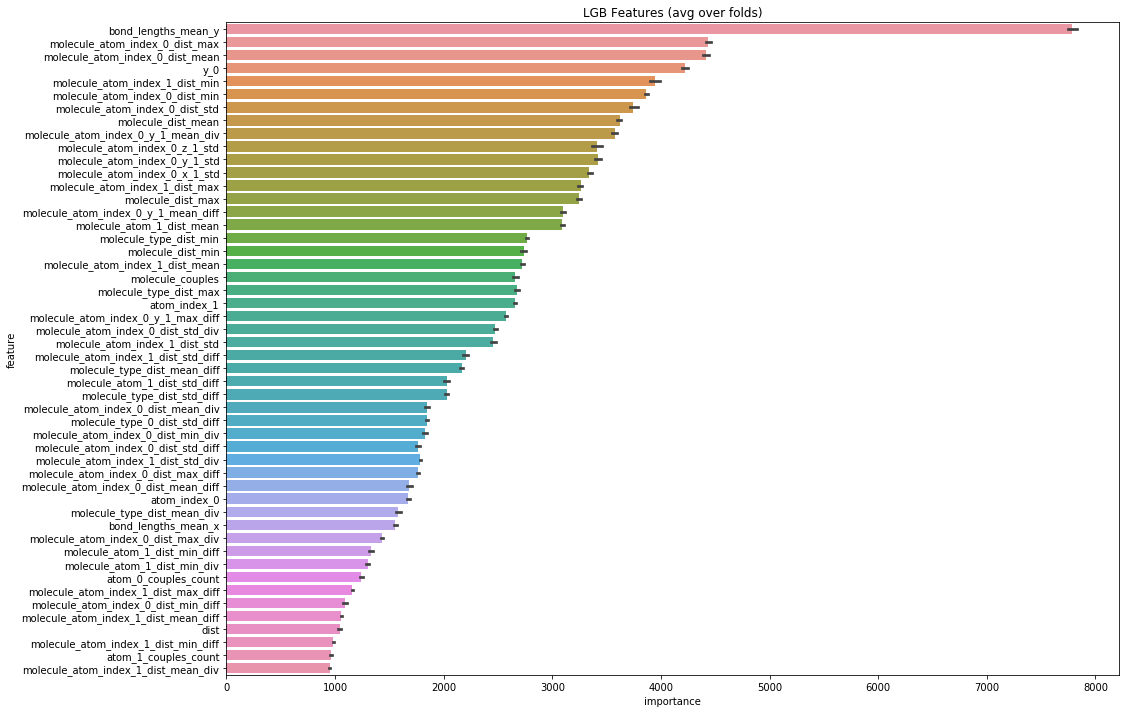

In [47]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb4 = train_model_regression(X=X, X_test=X_test, y=y_dso, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [48]:
oof_dso = result_dict_lgb4['oof']
test_oof_dso = result_dict_lgb4['prediction']

In [49]:
X['oof_fc'] = oof_fc
X_test['oof_fc'] = test_oof_fc

X['oof_sd'] = oof_sd
X_test['oof_sd'] = test_oof_sd

X['oof_pso'] = oof_pso
X_test['oof_pso'] = test_oof_pso

X['oof_dso'] = oof_dso
X_test['oof_dso'] = test_oof_dso

X['oof_scalar_cc'] = X['oof_fc'] + X['oof_sd'] + X['oof_pso'] + X['oof_dso']
X_test['oof_scalar_cc'] = X_test['oof_fc'] + X_test['oof_sd'] + X_test['oof_pso'] + X_test['oof_dso']

In [50]:
del result_dict_lgb1, result_dict_lgb2, result_dict_lgb3, result_dict_lgb4
gc.collect()

44924

Fold 1 started at Fri Jun 21 08:47:09 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0244551	valid_1's l1: 0.0254384
[1000]	training's l1: 0.0229922	valid_1's l1: 0.0247718
[1500]	training's l1: 0.0218602	valid_1's l1: 0.0243177
[2000]	training's l1: 0.0209137	valid_1's l1: 0.0239789
[2500]	training's l1: 0.0200771	valid_1's l1: 0.0237026
[3000]	training's l1: 0.0193121	valid_1's l1: 0.0234424
[3500]	training's l1: 0.0186103	valid_1's l1: 0.0232156
[4000]	training's l1: 0.0179696	valid_1's l1: 0.0230245
[4500]	training's l1: 0.0173808	valid_1's l1: 0.0228419
[5000]	training's l1: 0.0168221	valid_1's l1: 0.0226705
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.0168221	valid_1's l1: 0.0226705
Fold 2 started at Fri Jun 21 09:07:23 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.0246981	valid_1's l1: 0.0255482
[1000]	training's l1: 0.0231933	valid_1's l1: 0.0248032
[1500]	trainin

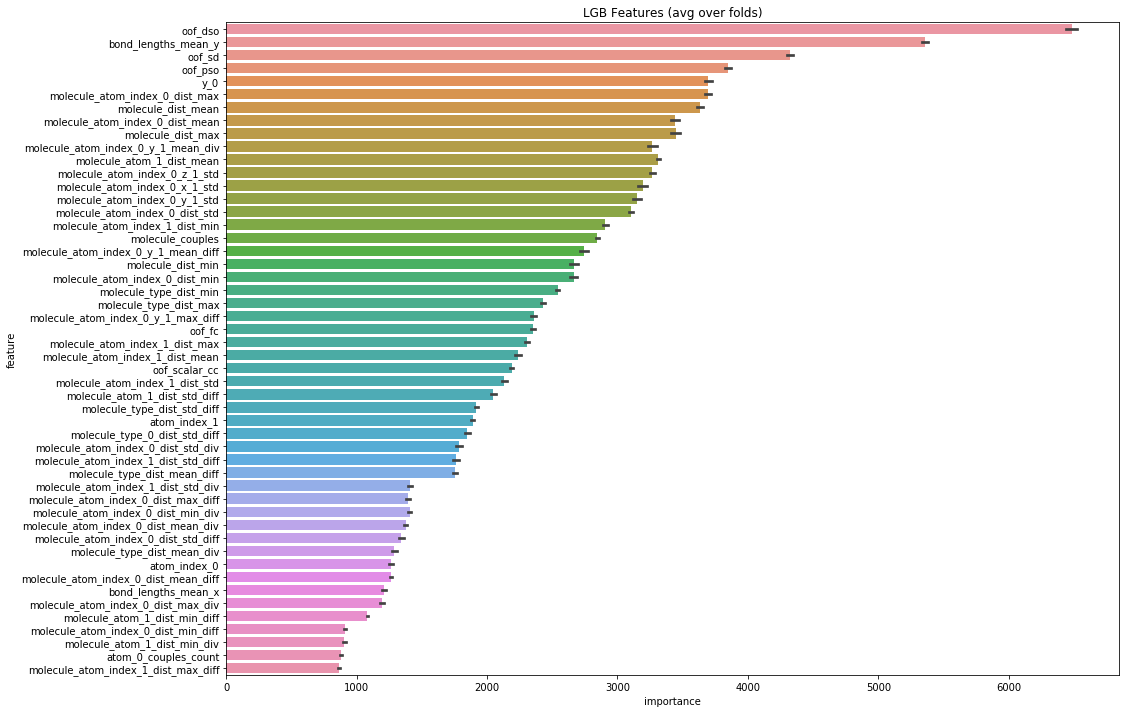

In [51]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)

In [52]:
y = y1
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print(f'Training of type {t}')
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target']
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
sub['scalar_coupling_constant'] = X_short_test['prediction']
sub.to_csv('../submissions/sub7.csv', index=False)
sub.head()

Training of type 0
Fold 1 started at Fri Jun 21 10:29:06 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.13476	valid_1's l1: 1.31318
[1000]	training's l1: 0.964589	valid_1's l1: 1.2892
[1500]	training's l1: 0.829662	valid_1's l1: 1.26994
[2000]	training's l1: 0.722388	valid_1's l1: 1.25769
[2500]	training's l1: 0.632471	valid_1's l1: 1.24678
[3000]	training's l1: 0.557175	valid_1's l1: 1.23902
[3500]	training's l1: 0.494271	valid_1's l1: 1.23243
[4000]	training's l1: 0.439945	valid_1's l1: 1.22792
[4500]	training's l1: 0.393334	valid_1's l1: 1.22384
[5000]	training's l1: 0.35221	valid_1's l1: 1.22036
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.35221	valid_1's l1: 1.22036
Fold 2 started at Fri Jun 21 10:33:00 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.12487	valid_1's l1: 1.31915
[1000]	training's l1: 0.953748	valid_1's l1: 1.29357
[1500]	training's l1: 0.820116	valid_1'

Fold 2 started at Fri Jun 21 11:02:04 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.248307	valid_1's l1: 0.586066
[1000]	training's l1: 0.119577	valid_1's l1: 0.568753
[1500]	training's l1: 0.0618836	valid_1's l1: 0.564684
[2000]	training's l1: 0.0319282	valid_1's l1: 0.563267
[2500]	training's l1: 0.0160445	valid_1's l1: 0.562735
[3000]	training's l1: 0.00813875	valid_1's l1: 0.562571
[3500]	training's l1: 0.004558	valid_1's l1: 0.562515
Early stopping, best iteration is:
[3329]	training's l1: 0.00543989	valid_1's l1: 0.562499
Fold 3 started at Fri Jun 21 11:02:31 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.245163	valid_1's l1: 0.577521
[1000]	training's l1: 0.118271	valid_1's l1: 0.562659
[1500]	training's l1: 0.0610698	valid_1's l1: 0.558745
[2000]	training's l1: 0.0318312	valid_1's l1: 0.557127
[2500]	training's l1: 0.0161787	valid_1's l1: 0.556778
[3000]	training's l1: 0.00821515	valid_1's 

Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.552392	valid_1's l1: 0.628296
[1000]	training's l1: 0.469813	valid_1's l1: 0.599631
[1500]	training's l1: 0.40965	valid_1's l1: 0.581934
[2000]	training's l1: 0.362343	valid_1's l1: 0.569911
[2500]	training's l1: 0.324011	valid_1's l1: 0.561558
[3000]	training's l1: 0.291951	valid_1's l1: 0.555312
[3500]	training's l1: 0.264475	valid_1's l1: 0.550078
[4000]	training's l1: 0.240554	valid_1's l1: 0.545844
[4500]	training's l1: 0.219504	valid_1's l1: 0.542734
[5000]	training's l1: 0.201081	valid_1's l1: 0.539895
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.201081	valid_1's l1: 0.539895
Fold 4 started at Fri Jun 21 11:28:14 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.55222	valid_1's l1: 0.626999
[1000]	training's l1: 0.470484	valid_1's l1: 0.598777
[1500]	training's l1: 0.410873	valid_1's l1: 0.581076
[2000]	training's l1: 0.363672	

Fold 4 started at Fri Jun 21 12:18:59 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.586254	valid_1's l1: 0.641662
[1000]	training's l1: 0.51932	valid_1's l1: 0.617381
[1500]	training's l1: 0.468054	valid_1's l1: 0.602235
[2000]	training's l1: 0.425566	valid_1's l1: 0.590374
[2500]	training's l1: 0.389418	valid_1's l1: 0.581162
[3000]	training's l1: 0.358395	valid_1's l1: 0.574268
[3500]	training's l1: 0.330925	valid_1's l1: 0.56846
[4000]	training's l1: 0.306411	valid_1's l1: 0.563653
[4500]	training's l1: 0.28462	valid_1's l1: 0.559593
[5000]	training's l1: 0.265162	valid_1's l1: 0.556407
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.265162	valid_1's l1: 0.556407
Fold 5 started at Fri Jun 21 12:26:19 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.587039	valid_1's l1: 0.642937
[1000]	training's l1: 0.519008	valid_1's l1: 0.617582
[1500]	training's l1: 0.466868	valid_1's l1

id  scalar_coupling_constant
0  4658147         8.294706133967981
1  4658148       188.008916798550075
2  4658149         6.602200139669009
3  4658150       188.941569452546048
4  4658151         7.840442800693876

In [53]:
%%time
!kaggle competitions submit -c champs-scalar-coupling -f ../submissions/sub7.csv -m ""

100%|██████████████████████████████████████| 64.0M/64.0M [00:16<00:00, 3.96MB/s]
Successfully submitted to Predicting Molecular PropertiesCPU times: user 581 ms, sys: 0 ns, total: 581 ms
Wall time: 19.7 s


In [55]:
from time import sleep
sleep(30)
!kaggle competitions submissions -c champs-scalar-coupling

fileName   date                 description  status    publicScore  privateScore  
---------  -------------------  -----------  --------  -----------  ------------  
sub7.csv   2019-06-21 07:11:21  None         complete  -1.009       None          
sub6.csv   2019-06-11 10:26:26  None         complete  -0.939       None          
sub5.csv   2019-06-10 01:33:16  None         complete  -0.854       None          
sub4a.csv  2019-06-09 09:26:24  None         complete  -0.830       None          
sub4.csv   2019-06-09 06:05:24  None         complete  -0.603       None          
sub4.csv   2019-06-09 06:03:59  None         complete  -0.196       None          
sub3.csv   2019-06-09 00:57:08  None         complete  -0.376       None          
sub2b.csv  2019-06-08 17:53:30  None         complete  -0.690       None          
sub2a.csv  2019-06-08 14:09:52  None         complete  -0.642       None          
sub2.csv   2019-06-08 13:03:54  None         complete  -0.400       None          
sub1

In [41]:
scalar_coupling_contributions.head()

molecule_name  atom_index_0  atom_index_1  type                  fc  \
0  dsgdb9nsd_000001             1             0  1JHC  83.022400000000005   
1  dsgdb9nsd_000001             1             2  2JHH -11.034700000000001   
2  dsgdb9nsd_000001             1             3  2JHH -11.032500000000001   
3  dsgdb9nsd_000001             1             4  2JHH -11.031900000000000   
4  dsgdb9nsd_000001             2             0  1JHC  83.022199999999998   

         sd      pso       dso  
0  0.254579  1.25862  0.272010  
1  0.352978  2.85839 -3.433600  
2  0.352944  2.85852 -3.433870  
3  0.352934  2.85855 -3.433930  
4  0.254585  1.25861  0.272013

In [3]:
0.254579	 +  1.25862 + 0.272010 + 83.022400000000005

84.807609